In [1]:
import matplotlib.pyplot as plt

import igraph as ig
import networkx as nx
from networkx.algorithms import bipartite

import pandas as pd
import numpy as np
from pandarallel import pandarallel
import swifter

from sklearn import preprocessing, model_selection
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_absolute_error
from sklearn.cluster import KMeans
import lightgbm as lgbm
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import xgboost as xgb

import re

from surprise import SVD, SVDpp, CoClustering, SlopeOne, KNNBasic, KNNWithZScore
from surprise import Dataset, Reader, accuracy
from surprise.model_selection import cross_validate as surprise_cv, GridSearchCV as surprise_grid_search_cv, train_test_split as surprise_test_train_split

from settings import file_names
from graph import *
from helpers import *

In [2]:
pandarallel.initialize()

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


# Datasets

In [3]:
df_reviews = pd.read_csv(file_names['toronto_reviews_without_text'])
df_users = pd.read_csv(file_names['toronto_users'])
df_biz = pd.read_csv(file_names['toronto_businesses'])

In [4]:
df_tips = pd.read_json(file_names['tip'], encoding='utf-8', lines=True)
df_tips = df_tips.loc[df_tips['user_id'].isin(df_users.user_id.unique()) & df_tips['business_id'].isin(df_biz.business_id.unique())]
print('Number of Tips: ', df_tips.shape[0])
df_tips.head(3)

Number of Tips:  33192


,user_id,business_id,text,date,compliment_count
7,CaFbX7topxdLpBJ_SNDfGQ,r49iBfbnfoK7yt4rdsL_7g,Hands down best AYCE in town! Love it!,2016-01-05 06:39:33,0
10,8zXgNCkusOHMwh5Tj_8yCQ,qrSsS0pk7SL67MP5nN8tlg,More parking in the back of the restaurant,2013-12-22 05:10:12,0
13,oIHhfloe5VQamDFDB2dr1Q,wZhB4U003eg2GQ-F7D2D4A,When you receive the bag of seafood tie it up ...,2016-08-12 22:18:07,0


In [5]:
print('Number of reviews: ',df_reviews.shape[0])
print('Ratings describe: ', df_reviews['rating'].describe())
df_reviews.head(3)



Number of reviews:  228816
Ratings describe:  count    228816.000000
mean          3.643093
std           1.139687
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64


,user_id,business_id,rating,date
0,TpyOT5E16YASd7EWjLQlrw,AakkkTuGZA2KBodKi2_u8A,1.0,2012-07-16 00:37:14
1,_N7Ndn29bpll_961oPeEfw,y-Iw6dZflNix4BdwIyTNGA,3.0,2014-06-27 21:19:23
2,54kpqrxF9DEPpwa51hO_Bw,jzveTy7ogH7cg9axZ78ENg,4.0,2015-04-01 13:31:35


In [6]:
print('Number of users: ',df_users.shape[0])
df_users.head(3)

Number of users:  18804


,user_id,friends
0,gvXtMj3XuPr0xHjgmlmtng,"CfGCj80EdA-xS-mTWlAn4Q, JgD2Rk9K07MkZgG7Nb9YzA..."
1,pU6GoRTcl1rIOi6zMynjog,"SwK2Oo8sjOH0yXYVoyjJwQ, 1LpChUg-0EqRKRKzL4ogYA..."
2,AsYMm_O4H-mwmWbmeACDHw,"w-bVY-dhpvnNs8W3BTTgAA, o_OEO0ES7oywPqENQR0f3A..."


In [7]:
print('Number of businesses: ',df_biz.shape[0])
df_biz.head(3)

Number of businesses:  7965


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,attributes,categories
0,NDuUMJfrWk52RA-H-OtrpA,Bolt Fresh Bar,1170 Queen Street W,Toronto,ON,M6J 1J5,43.642889,-79.425429,3.0,57,"{'WiFi': ""u'no'"", 'BikeParking': 'True', 'Rest...","Juice Bars & Smoothies, Food, Restaurants, Fas..."
1,SP_YXIEwkFPPl_9anCYmpQ,The Steady Cafe & Bar,1051 Bloor Street W,Toronto,ON,M6H 1M4,43.660494,-79.432099,3.5,29,"{'BusinessParking': ""{'garage': False, 'street...","Restaurants, Nightlife, Breakfast & Brunch, Ve..."
2,mlHC2XcU9Bows6cnYEmRgg,Mad Crush Wine Bar,582 College Street,Toronto,ON,M6G 1B3,43.655420,-79.413352,4.0,9,"{'Alcohol': ""u'full_bar'"", 'Caters': 'False', ...","Restaurants, Breakfast & Brunch, Bars, Modern ..."


# Baseline Binary Prediction - Collaborative Filtering

#### Build input data for recommender:

In [8]:
g_bi = make_user_business_bipartite_graph(weighted=False, minimum_rating=0)

In [9]:
users = {n for n, d in g_bi.nodes(data=True) if d['bipartite']==0}
businesses = set(g_bi) - users
print(len(users), len(businesses), len(set(g_bi)))

18802 7860 26662


In [10]:
df_binary = get_binary_df(g_bi)
df_binary.head(3)

,user_id,business_id,has_reviewed
0,XChCfeJ6Yx2NDJIpIgRhyg,BtJQ8pzAmiAmDsytDfxdFA,0
1,Ewzycs8MTQN6G9MRE9ZzNQ,BtJQ8pzAmiAmDsytDfxdFA,0
2,KNygNoqUiYhj1udbFp9Q8A,BtJQ8pzAmiAmDsytDfxdFA,0


#### Build, train and evaluate recommender:

In [11]:
reader = Reader(rating_scale=(0, 1))

data = negative_sampling(df_binary, 1)
print(data.shape)
data = Dataset.load_from_df(data, reader)

algo = SVDpp(n_factors=10, n_epochs=30, init_mean=0.5)

trainset, testset = surprise_test_train_split(data, test_size=.25)
algo.fit(trainset)

predictions = algo.test(testset)
print(accuracy.fcp(predictions, verbose=True), accuracy.mae(predictions, verbose=True))

(441858, 3)
FCP:  0.6826
MAE:  0.2822
0.682568824168249 0.2821571919393476


#### Precision of the recommender: Percentage of Top 1 recommendation that actually corresponds to a visit

In [12]:
from helpers import get_top_n

top_pred = get_top_n(predictions, n=1)
user_ids = list(top_pred.keys())
business_ids = [top_pred[0][0] for top_pred in list(top_pred.values())]

df_top_pred_test = pd.DataFrame({'user_id':user_ids, 'business_id':business_ids})

df_top_pred_test = pd.merge(df_top_pred_test,df_binary, how='left', on=['user_id','business_id'])
df_top_pred_test.head(3)

,user_id,business_id,has_reviewed
0,eRDWzHCldd6YXypRECvHYg,k6zmSLmYAquCpJGKNnTgSQ,1
1,9u-RaRsyK6gFazDUdH_b2w,4MQaqhBUJCpghGukSWNq7w,0
2,b9Cfa7tkxrl8zuH7yEvEPg,ABRgXNwdOX_JyqChNr8IYw,1


In [13]:
print('precision of top 1 recommender: {}'.format(df_top_pred_test['has_reviewed'].mean()))
print('Note that a random recommender would have a precision of : {}'.format(df_binary['has_reviewed'].mean()))

precision of top 1 recommender: 0.5860133822577164
Note that a random recommender would have a precision of : 0.0014949481580244428


# Binary Prediction - Using Graph Analysis
- Community detection
    - User --[Friends]-->User
        - and build features: percentage of user from this cluster who went to each restaurant, size of cluster
    - User --[Reviewed]-->Restaurant
        - and build features: is_in_same_cluster, distance between clusters
    - User --[Friends]-->User & User --[Reviewed]-->Restaurant   (and build features: is_in_same_cluster, distance between clusters)
        - idem
    - User --[distance with reviewed restaurant using geolocalisation]-->Reastaurant
        - idem
- Centrality measures on restaurants


### Train, Test & Validation Data

In [14]:
data = {}

In [15]:
for mode in ['train', 'test']:
    data[mode] = pd.read_csv('Exp Results/binary_{}_random_split.csv'.format(mode), index_col=0)

In [16]:
for key in data.keys():
    print(key,data[key].shape,'\n')
data['train'].head(3)

train (355884, 3) 

test (90792, 3) 



,user_id,business_id,has_reviewed
0,6SEWI-AjlmUOuw0vvb-IHg,AcCrkVSrZ9qShuPhXYDgGQ,0
1,im7-S1-vlgKurQueGl27Tg,y1Er-SodAde9QZIcgFf45g,0
2,_thKTYMwP4VnI3hhKeeCyQ,YRWGkDCSVVu6LU5tOjMGyQ,0


### Recommender

In [17]:
for key in data.keys():
    data[key] = pd.read_csv('Exp Results/binary_and_reco_{}_random_split.csv'.format(key), index_col=0)
data['train'].head(3)

,user_id,business_id,has_reviewed,reco
0,6SEWI-AjlmUOuw0vvb-IHg,AcCrkVSrZ9qShuPhXYDgGQ,0,0.0
1,im7-S1-vlgKurQueGl27Tg,y1Er-SodAde9QZIcgFf45g,0,0.0
2,_thKTYMwP4VnI3hhKeeCyQ,YRWGkDCSVVu6LU5tOjMGyQ,0,0.0


### Friends Graph

#### Clustering

In [18]:
for key in data.keys():
    data[key] = pd.read_csv('Exp Results/binary_and_infomap_{}_random_split.csv'.format(key), index_col=0)
print('train data: ','\n')
data['train'].head(3)

train data:  



,user_id,business_id,has_reviewed,reco,user_infomap_friends
0,6SEWI-AjlmUOuw0vvb-IHg,AcCrkVSrZ9qShuPhXYDgGQ,0,0.0,4275
1,im7-S1-vlgKurQueGl27Tg,y1Er-SodAde9QZIcgFf45g,0,0.0,3763
2,_thKTYMwP4VnI3hhKeeCyQ,YRWGkDCSVVu6LU5tOjMGyQ,0,0.0,5471


nb_users:  18802
nb_communities:  5964


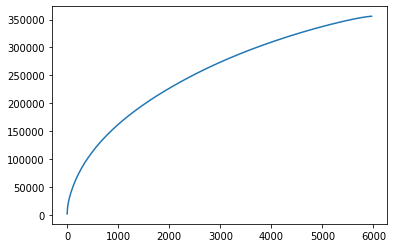

In [19]:
df_infomap_friends = data['train']
print('nb_users: ',len(df_infomap_friends['user_id'].unique()))
print('nb_communities: ',len(df_infomap_friends['user_infomap_friends'].unique()))

plt.plot(np.cumsum(sorted(df_infomap_friends.groupby(by='user_infomap_friends').count()['user_id'].values, reverse = True)))

#### Merge Small Communities

In [20]:
def merge_small_communities(data, community_name, min_commnuity_size = 10):
    community_sizes = data['train'].groupby(community_name).count()
    small_communities = community_sizes.loc[community_sizes['reco']<min_commnuity_size].index.values
    data['train'][community_name] = data['train'][community_name].replace(dict.fromkeys(small_communities, -1))
    data['test'][community_name] = data['test'][community_name].replace(dict.fromkeys(small_communities, -1))
    return data

In [21]:
data = merge_small_communities(data, community_name = 'user_infomap_friends', min_commnuity_size = 1)

In [22]:
data['train'].head(3)

,user_id,business_id,has_reviewed,reco,user_infomap_friends
0,6SEWI-AjlmUOuw0vvb-IHg,AcCrkVSrZ9qShuPhXYDgGQ,0,0.0,4275
1,im7-S1-vlgKurQueGl27Tg,y1Er-SodAde9QZIcgFf45g,0,0.0,3763
2,_thKTYMwP4VnI3hhKeeCyQ,YRWGkDCSVVu6LU5tOjMGyQ,0,0.0,5471


#### Features

In [23]:
def get_proportion_of_restaurant_reviewers_in_community(df_train, community_name):
    df = df_train.copy()
    
    community_size = df.groupby(by=[community_name], as_index=False)['user_id'].count()
    community_size.rename({'user_id':'size_{}'.format(community_name)}, inplace=True, axis=1)
    community_size[community_name] = community_size.index.values

    restaurant_reviewers = df.loc[df['has_reviewed']==1].groupby(by=[community_name,'business_id'], as_index=False)['reco'].count()
    df = pd.merge(restaurant_reviewers, community_size, how='left').fillna(0)
    df['proportion_{}'.format(community_name)] = df['reco'] / (df['size_{}'.format(community_name)]+1)
    community_proportions = df[[community_name, 'business_id', 'proportion_{}'.format(community_name)]].fillna(0)
    
    return community_size, community_proportions

In [24]:
community_size, community_proportions = get_proportion_of_restaurant_reviewers_in_community(data['train'], 'user_infomap_friends')

features = pd.merge(community_proportions, community_size, how = 'left', on = ['user_infomap_friends']).fillna(0)

for key in data.keys():
    data[key] = pd.merge(data[key], features, how = 'left', on = ['user_infomap_friends','business_id']).fillna(0)

In [41]:
data['train'].head(3)

,user_id,business_id,has_reviewed,reco,user_infomap_friends,proportion_user_infomap_friends,size_user_infomap_friends,infomap_full_indicator
0,6SEWI-AjlmUOuw0vvb-IHg,AcCrkVSrZ9qShuPhXYDgGQ,0,0.0,-1,0.0,0.0,0
1,im7-S1-vlgKurQueGl27Tg,y1Er-SodAde9QZIcgFf45g,0,0.0,-1,0.0,0.0,0
2,_thKTYMwP4VnI3hhKeeCyQ,YRWGkDCSVVu6LU5tOjMGyQ,0,0.0,-1,0.0,0.0,0


#### Classifier

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [28]:
clf = LogisticRegression()

X_train = data['train'][['reco']].values
y_train = data['train']['has_reviewed'].values

X_test = data['test'][['reco']].values
y_test = data['test']['has_reviewed'].values

clf.fit(X_train, y_train)
print('train_mae: ',mean_absolute_error(clf.predict(X_train), y_train),'\ntest_mae: ', mean_absolute_error(clf.predict(X_test), y_test))

train_mae:  0.14607849748794552 
test_mae:  0.19764957264957264


In [29]:
clf.predict(X_train)

array([0, 0, 0, ..., 1, 0, 0])

In [30]:
clf = LogisticRegression()

X_train = data['train'][['size_user_infomap_friends','proportion_user_infomap_friends']].values
y_train = data['train']['has_reviewed'].values

X_test = data['test'][['size_user_infomap_friends','proportion_user_infomap_friends']].values
y_test = data['test']['has_reviewed'].values

clf.fit(X_train, y_train)
print('train_mae: ',mean_absolute_error(clf.predict(X_train), y_train),
      '\ntest_mae: ', mean_absolute_error(clf.predict(X_test), y_test))

train_mae:  0.0036641152735160895 
test_mae:  0.4536743325403119


### Full Graph (user-user-business)

In [31]:
for key in data.keys():
    data[key] = pd.read_csv('Exp Results/binary_and_infomap_full_weight_ratio1{}_random_split.csv'.format(key), index_col=0)
print('train data','\n')
data['train'].head(3)

train data 



,user_id,business_id,has_reviewed,reco,user_infomap_friends,proportion_user_infomap_friends,size_user_infomap_friends,infomap_full_indicator,user_infomap_full,business_infomap_full
0,6SEWI-AjlmUOuw0vvb-IHg,AcCrkVSrZ9qShuPhXYDgGQ,0,0.0,-1,0.0,0.0,0,32,923
1,im7-S1-vlgKurQueGl27Tg,y1Er-SodAde9QZIcgFf45g,0,0.0,-1,0.0,0.0,0,111,250
2,_thKTYMwP4VnI3hhKeeCyQ,YRWGkDCSVVu6LU5tOjMGyQ,0,0.0,-1,0.0,0.0,0,1470,899


In [32]:
min_commnuity_size = 1
data = merge_small_communities(data, community_name = 'user_infomap_full', min_commnuity_size=min_commnuity_size)
data = merge_small_communities(data, community_name = 'business_infomap_full', min_commnuity_size=min_commnuity_size)

nb_users:  18802
nb_communities:  1480


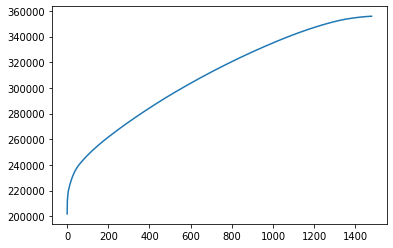

In [33]:
df_infomap_full = data['train']
print('nb_users: ',len(df_infomap_full['user_id'].unique()))
print('nb_communities: ',len(df_infomap_full['user_infomap_full'].unique()))

plt.plot(np.cumsum(sorted(df_infomap_full.groupby(by='user_infomap_full').count()['user_id'].values, reverse = True)))

In [34]:
data['train'].head(3)

,user_id,business_id,has_reviewed,reco,user_infomap_friends,proportion_user_infomap_friends,size_user_infomap_friends,infomap_full_indicator,user_infomap_full,business_infomap_full
0,6SEWI-AjlmUOuw0vvb-IHg,AcCrkVSrZ9qShuPhXYDgGQ,0,0.0,-1,0.0,0.0,0,32,923
1,im7-S1-vlgKurQueGl27Tg,y1Er-SodAde9QZIcgFf45g,0,0.0,-1,0.0,0.0,0,111,250
2,_thKTYMwP4VnI3hhKeeCyQ,YRWGkDCSVVu6LU5tOjMGyQ,0,0.0,-1,0.0,0.0,0,1470,899


In [35]:
for key in data.keys():
    data[key]['infomap_full_indicator'] = (data[key]['business_infomap_full'] == data[key]['user_infomap_full']) * 1
    data[key].drop(['business_infomap_full','user_infomap_full'], axis=1, inplace=True)
print('train data','\n')
data['train'].head(3)

train data 



,user_id,business_id,has_reviewed,reco,user_infomap_friends,proportion_user_infomap_friends,size_user_infomap_friends,infomap_full_indicator
0,6SEWI-AjlmUOuw0vvb-IHg,AcCrkVSrZ9qShuPhXYDgGQ,0,0.0,-1,0.0,0.0,0
1,im7-S1-vlgKurQueGl27Tg,y1Er-SodAde9QZIcgFf45g,0,0.0,-1,0.0,0.0,0
2,_thKTYMwP4VnI3hhKeeCyQ,YRWGkDCSVVu6LU5tOjMGyQ,0,0.0,-1,0.0,0.0,0


In [36]:
Counter(data['train']['infomap_full_indicator'])

Counter({0: 192940, 1: 162944})

### Classifier using full graph features only

In [37]:
clf = LogisticRegression()

X_train = data['train'][['infomap_full_indicator']].values
y_train = data['train']['has_reviewed'].values

X_test = data['test'][['infomap_full_indicator']].values
y_test = data['test']['has_reviewed'].values

clf.fit(X_train, y_train)
print('train_mae: ',mean_absolute_error(clf.predict(X_train), y_train),
      '\ntest_mae: ', mean_absolute_error(clf.predict(X_test), y_test))

train_mae:  0.2517674298366884 
test_mae:  0.2830425588157547


### Classifier using friends graph & full graph features

In [38]:
clf = LogisticRegression()

X_train = data['train'][['size_user_infomap_friends','proportion_user_infomap_friends','infomap_full_indicator']].values
y_train = data['train']['has_reviewed'].values

X_test = data['test'][['size_user_infomap_friends','proportion_user_infomap_friends','infomap_full_indicator']].values
y_test = data['test']['has_reviewed'].values

clf.fit(X_train, y_train)
print('train_mae: ',mean_absolute_error(clf.predict(X_train), y_train),
      '\ntest_mae: ', mean_absolute_error(clf.predict(X_test), y_test))

train_mae:  0.2199593125849996 
test_mae:  0.2795400475812847


# Future Work

### Use a different train/evaluation method.
For a recommender, use more a leave one out like approach.  
With our current approach, we will never suggest a restaurant that open this year, which is a huge problem.

### Use coordinates
Could be used to build a graph or relevant features

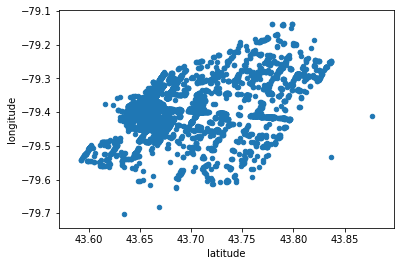

In [39]:
coordinates = df_biz[['latitude', 'longitude']]
coordinates.plot.scatter('latitude','longitude')

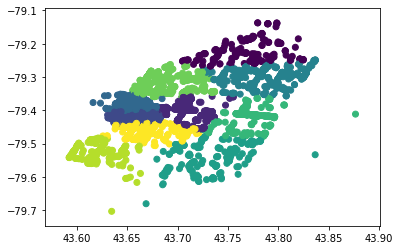

In [40]:
clf = KMeans(n_clusters=10)
clf.fit(coordinates)
coordinates_clusters = clf.labels_
plt.scatter(x = coordinates['latitude'], y = coordinates['longitude'], c=coordinates_clusters)